## Isolation Forest

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from pprint import pprint
import seaborn as sns
import pdb
sns.set_style(style="whitegrid")
from matplotlib import rcParams

%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['text.color'] = 'Black'
rcParams['figure.figsize'] = 16,8

## Sample Data 생성

### 1. Normal Data 생성

In [106]:
mean = [0, 0]
covariance = [[1, 0], [0, 1]]  # diagonal covariance
num = 2000
x, y = np.random.multivariate_normal(mean, covariance, num).T # 다변량 정규분포 데이터 생성

### 2. Outlier Data 생성

In [107]:
def create_outlier(x, y, numbers):
    '''
    Create number of outliers 
    '''
    for i in range(numbers):
        
        x[i] = np.random.normal(4, 1, 1) # mu, sigma, num
        y[i] = np.random.normal(4, 1, 1) # mu, sigma, num

In [109]:
create_outlier(x,y,10) # 10개의 이상치 데이터 생성

### 3. Dateset 생성 및 분포 시각화

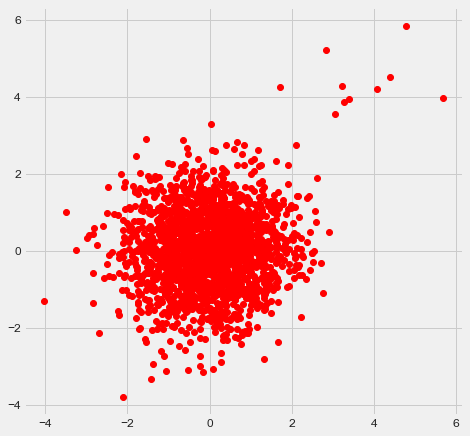

In [110]:
Data= np.array([x,y]).T
Data = pd.DataFrame(Data,columns=['Feature1','Feature2'])
plt.figure(figsize=(7,7))
plt.plot(x,y,'ro')
plt.show()

## Isolation Tree

In [100]:
def select_attribute(data):
    '''
    Isolation을 진행하기 위해 랜덤으로 변수 선택
    '''
    return random.choice(data.columns)

def split_point(data, columns):
    '''
    랜덤으로 선택된 변수 중에서 split point 선정
    '''
    min = np.min(data[columns])
    max = np.max(data[columns])
    
    split = (max - min)*np.random.random() + min
    
    return split

def split_data(data, attribute, splitpoint):
    '''
    split point 기준으로 데이터 분할
    '''
    data_up = data[data[attribute] > splitpoint]
    data_down = data[data[attribute] <= splitpoint]
    
    return data_up, data_down

def data_classification(data):
    '''
    '''
    colummn_values = data.values[:,-1] # 1?
    unique_values, value_counts = np.unique(colummn_values, return_counts=True)
    value_index = value_counts.argmax()
    classification = unique_values[value_index]
    
    return classification

## Isolation Tree

In [136]:
def isolation_tree(data, count=0, max_depth=50):
    
    
    if (count == max_depth) or data.shape[0] <=1: 
        classification = data_classification(data)
        
        return classification
    
    else:
        # count
        count += 1
        
        # 변수 선택
        attribute = select_attribute(data)
        
        # 분할점 선택
        split = split_point(data, attribute)
        
        # 분할점 기준 분할
        data_up, data_down = split_data(data, attribute, split)
        
        # 분할 시도
        split_try = "{} =< {}".format(attribute, split)
        # split_try = f"변수 {attribute}에 {split}보다 작거나 같은 값은"
        # sub_tree dictionary에 저장
        sub_tree = {split_try: []}
        
        answer_up = isolation_tree(data_up, count, max_depth=max_depth) 
        answer_down = isolation_tree(data_down, count, max_depth=max_depth)
        
        if answer_down == answer_up:
            sub_tree = answer_down
        
        else:
            sub_tree[split_try].append(answer_down)
            sub_tree[split_try].append(answer_up)
        
        
        return sub_tree

In [137]:
tree = isolation_tree(Data, max_depth=1)
print(tree)

{'Feature2 =< -2.676138005416277': [-3.790447632657338, -2.660760494948171]}


## Isolation Forest

In [141]:
def isolation_forest(data, num_trees=5, max_depth=5, subspace=256):
    
    forest = []

    for i in range(num_trees):
        # Sample the subspace
        if subspace<=1:
            data = data.sample(frac=subspace)
        else:
            data = data.sample(subspace)
        

        # Fit tree
        tree = isolation_tree(data, max_depth=max_depth)
        
        # Save tree to forest
        forest.append(tree)
    
    return forest

In [142]:
isolation_forest(Data, num_trees=5, max_depth=1)

[{'Feature1 =< 0.23962611358496844': [-3.1499016004026963,
   -2.8023532782538494]},
 {'Feature2 =< -2.320898334261837': [-3.1499016004026963, -2.036004655760361]},
 {'Feature1 =< -1.843377767264755': [-0.11272690523426825,
   -3.1499016004026963]},
 {'Feature1 =< 1.778152518138063': [-3.1499016004026963,
   -0.41901763506293827]},
 {'Feature2 =< -1.2270951857834862': [-3.1499016004026963,
   -1.2265126749387414]}]

## Path Length

In [131]:
def pathLength(example, iTree, path=0, trace=False):
    
    path = path+1
    question = list(iTree.keys())[0]
    
    feature_name, _, value = question.split() # "{} =< {}".format(attribute, split)
    
    # ask question
    if example[feature_name].values <= float(value):
        answer = iTree[question][0]
    else:
        answer = iTree[question][1]
        
        
    # base case
    if not isinstance(answer, dict):
        return path
    
    # recursive part
    else:
        residual_tree = answer
        return pathLength(example, residual_tree,path=path)

    return path

In [143]:
tree = isolation_tree(Data,max_depth=3)

In [147]:
ins = Data.sample(1)
pathLength(ins,tree)

3

## Plot

In [154]:
def makeline(data,example,iTree,path=0,line_width=1):
    
    #line_width = line_width +2
    path=path+1
    question = list(iTree.keys())[0]
    feature_name, comparison_operator, value = question.split()
    print(question)
    
    # ask question
    if example[feature_name].values <= float(value):
        answer = iTree[question][0]
        data = data[data[feature_name] <= float(value)]
    else:
        answer = iTree[question][1]
        data = data[data[feature_name] > float(value)]
        

    if feature_name == 'Feature1':
        plt.hlines(float(value),xmin=data.Feature1.min(),xmax=data.Feature1.max(),linewidths=line_width)
    else:
        plt.vlines(float(value),ymin=data.Feature2.min(),ymax=data.Feature2.max(),linewidths=line_width)
             
        
    # base case
    if not isinstance(answer, dict):
        return path
    
    # recursive part
    else:
        if feature_name == 'Feature1':
            plt.hlines(float(value),xmin=data.Feature1.min(),xmax=data.Feature1.max(),linewidths=line_width)
        else:
            plt.vlines(float(value),ymin=data.Feature2.min(),ymax=data.Feature2.max(),linewidths=line_width)
        residual_tree = answer
        return makeline(data,example, residual_tree,path=path,line_width=line_width)
    
    return path

In [155]:
def make_plot(data,example,iTree):
    plt.figure()
    plt.plot(data['Feature1'],data['Feature2'],'bo',alpha=0.2)
    plt.xlabel('Feature1')
    plt.ylabel('Feature2')
    #plt.xlim(data.Feature1.min(),data.feat1.max())
    plt.ylim(-3,3)
    plt.xlim(-3,3)
      
    
    # Plot H,v line
    makeline(data,example,tree)
    

    # Plot the point we are looking for
    plt.scatter(x=example.Feature1,y=ins.Feature2,c='r',marker='o')
    
    plt.show()

      Feature1  Feature2
1294   0.25038 -0.148648
Feature2 =< 0.5568323672079454
Feature2 =< -2.616141783971648
Feature2 =< -1.235084331197673
Feature2 =< -0.6565941147878182
Feature1 =< 0.5813840078712211


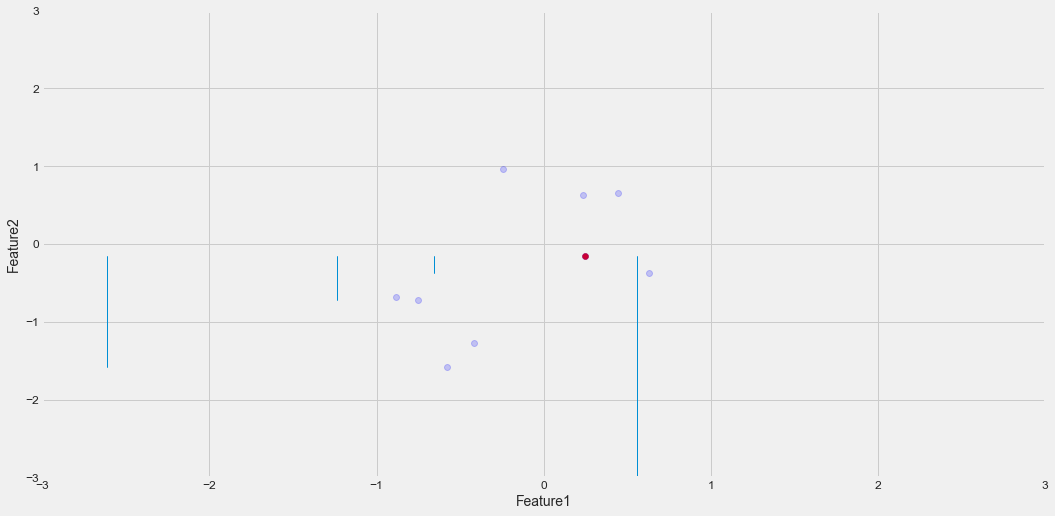

In [156]:
data_plot = Data.sample(10)
ins = data_plot.sample(1)
print(ins)

tree = isolation_tree(data_plot,max_depth=50)
make_plot(data_plot,ins,tree)

## Evaluate

In [160]:

iForest = isolation_forest(Data, num_trees=20, max_depth=100, subspace=256)

In [161]:
def evaluate_instance(instance,forest):
    paths = []
    for tree in forest:
        paths.append(pathLength(instance,tree))
    return paths 

In [162]:
def c_factor(n) :
    """
    Average path length of unsuccesful search in a binary search tree given n points
    
    Parameters
    ----------
    n : int
        Number of data points for the BST.
    Returns
    -------
    float
        Average path length of unsuccesful search in a BST
        
    """
    return 2.0*(np.log(n-1)+0.5772156649) - (2.0*(n-1.)/(n*1.0))


In [163]:
def anomaly_score(data_point,forest,n):
    '''
    Anomaly Score
    
    Returns
    -------
    0.5 -- sample does not have any distinct anomaly
    0 -- Normal Instance
    1 -- An anomaly
    '''
    # Mean depth for an instance
    E = np.mean(evaluate_instance(data_point,forest))
    
    c = c_factor(n)
    
    return 2**-(E/c)

## Evaluate whole dataset

In [164]:
an= []
for i in range(Data.shape[0]):
    an.append(anomaly_score(Data.iloc[[i]],iForest,256))

In [165]:
def instance_depth_plot(instance,outlier,forest):
    bars1 = evaluate_instance(outlier,forest)

    bars2 = evaluate_instance(instance,forest)

    # width of the bars
    barWidth = 0.3

    # The x position of bars
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    
    # Create cyan bars
    plt.bar(r2, bars2, width = barWidth, capsize=7, label='Normal Sample')

    # Create blue bars
    plt.bar(r1, bars1, width = barWidth,  capsize=7, label='Outlier')
    #sns.barplot(x=r1, y=bars1,capsize=7, label='Outlier')

    
    #sns.barplot(x=r2, y=bars2, label='Normal')
    
    # general layout

    plt.ylabel('Tree Depth')
    plt.xlabel('Trees')
    plt.legend()

    # Show graphic
    plt.savefig('images/normal_vs_outlier.png')

    plt.show()

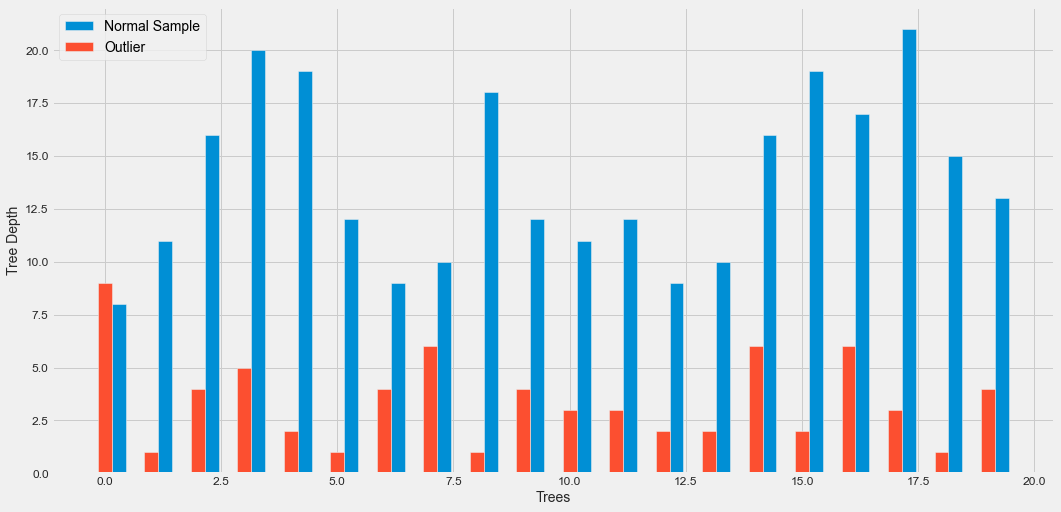

In [168]:
instance_depth_plot(Data.sample(1),
                    Data.head(1),
                    iForest)

In [169]:

outlier  = evaluate_instance(Data.head(1),iForest)
normal  = evaluate_instance(Data.sample(1),iForest)

In [170]:
np.mean(outlier)

3.45

In [171]:
np.mean(normal)

12.65

In [174]:
iForest = isolation_forest(Data, num_trees=20, max_depth =100, subspace=1_560)

In [177]:
print('Anomaly score for outlier:',anomaly_score(Data.head(0), iForest,1560))
print('Anomaly score for normal:',anomaly_score(Data.sample(1),iForest,1560))

Anomaly score for outlier: 0.7905221843663564
Anomaly score for normal: 0.3789867273701014


C:\Users\changhyun\AppData\Local\Temp\ipykernel_34640\3650187539.py:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if example[feature_name].values <= float(value):
